# Прогнозування шахрайських транзакцій
__Метою__ даного дослідження є навчити класифікатор класифікувати транзакції на шахрайські (той випадок, коли шахраї викрадають кошти з карт) та звичайні транзакції (ті, що відбуваються між звичайними людьми) на основі набору характеристик щодо проведення транзакцій.

Дана задача буде вирішена за допомогою бінарної класифікації з використанням Scikit-Learn та за допомогою реалізації таких алгоритмів 
- метод k-найближчих сусідів (K-Nearest Neighbors);
- метод опорних векторів (Support Vector Machines);
- логічна регресія (Logistic Regression).

In [1]:
#імпортуємо необхідні бібліотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# зчитаємо файл з початковими даними в датафрейм df
df = pd.read_csv('Fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
941458,95,CASH_OUT,132557.35,C1179511630,479803.00,347245.65,C435674507,484329.37,616886.72,0,0
941459,95,PAYMENT,9917.36,C1956161225,90545.00,80627.64,M668364942,0.00,0.00,0,0
941460,95,PAYMENT,14140.05,C2037964975,20545.00,6404.95,M1355182933,0.00,0.00,0,0
941461,95,PAYMENT,10020.05,C1633237354,90605.00,80584.95,M1964992463,0.00,0.00,0,0


### Опис датафрейму  
Цей набір даних містив інформацію про 6 362 620 тракзакцій, але для того, щоб було більш зручніше проводити дослудження, було вирішено залишити інформацію про 941 463 записів.

Датасет містить 10 факторів і 1 цільову змінну. Факторами є наступні характеристики проведених транзакцій:

**step** - відображає одиницю часу в реальному світі. У цьому випадку 1 крок – це 1 година часу.

**type** - тип проведеної транзакції : CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

**amount** - сума операції в місцевій валюті.

**nameOrig** - клієнт, який розпочав транзакцію

**oldbalanceOrg** - початковий баланс перед транзакцією

**newbalanceOrig** - новий баланс після транзакції

**nameDest** - клієнт, який є одержувачем транзакції

**oldbalanceDest** - початковий баланс перед транзакцією на рахунку одержувача

**newbalanceDest** - новий баланс після транзакції на рахунку одержувача

**isFraud** - це транзакції, здійснені шахрайськими агентами всередині симуляції. У цьому конкретному наборі даних шахрайська поведінка агентів спрямована на отримання прибутку, захоплюючи контрольні або клієнтські рахунки та намагаючись спустошити кошти шляхом переказу на інший рахунок, а потім виведення коштів із системи. Дана змінна і є головним класифікатором.

**0 - транзакція не є шахрайською
1 - транзакція визначена як шахрайська**

**isFlaggedFraud** - бізнес-модель спрямована на контроль масових переказів з одного облікового запису на інший і позначає незаконні спроби. Незаконна спроба в цьому наборі даних – це спроба передати більше 200 000 за одну транзакцію.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941463 entries, 0 to 941462
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            941463 non-null  int64  
 1   type            941463 non-null  object 
 2   amount          941463 non-null  float64
 3   nameOrig        941463 non-null  object 
 4   oldbalanceOrg   941463 non-null  float64
 5   newbalanceOrig  941463 non-null  float64
 6   nameDest        941463 non-null  object 
 7   oldbalanceDest  941463 non-null  float64
 8   newbalanceDest  941463 non-null  float64
 9   isFraud         941463 non-null  int64  
 10  isFlaggedFraud  941463 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 79.0+ MB


Типи даних визначені правильно. Кількисними є усі показники, окрім назв клієнтів і типу проведеної транзакції.

Нульових значень немає. Усі рядки і стовпці заповнені.

Для проведення класифікації було вирішено видалити ті фактори, що суттєво не впливатимуть на класифікайцію. 

Серед яких: **step**, бо проміжок часу ніяк не впливає на характер транзакції. Також для класифікацї неважливими є **nameOrig** та **nameDest**, що вказують на ім'я клієнта, що розпочав і що отримав транзакцію.

In [5]:
df.drop(['step'], axis=1, inplace=True)
df.drop(['nameOrig'], axis=1, inplace=True)
df.drop(['nameDest'], axis=1, inplace=True)
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...
941458,CASH_OUT,132557.35,479803.00,347245.65,484329.37,616886.72,0,0
941459,PAYMENT,9917.36,90545.00,80627.64,0.00,0.00,0,0
941460,PAYMENT,14140.05,20545.00,6404.95,0.00,0.00,0,0
941461,PAYMENT,10020.05,90605.00,80584.95,0.00,0.00,0,0


In [6]:
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,9.414630e+05,9.414630e+05,9.414630e+05,9.414630e+05,9.414630e+05,941463.000000,941463.0
mean,1.620576e+05,8.784096e+05,8.991832e+05,9.877584e+05,1.129649e+06,0.000552,0.0
std,2.617744e+05,2.973557e+06,3.010646e+06,2.309683e+06,2.432874e+06,0.023495,0.0
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,1.290797e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,8.021414e+04,1.591800e+04,0.000000e+00,1.333269e+05,2.310088e+05,0.000000,0.0
75%,2.189869e+05,1.408610e+05,1.813015e+05,9.270892e+05,1.172408e+06,0.000000,0.0
max,1.000000e+07,3.893942e+07,3.894623e+07,4.205466e+07,4.216916e+07,1.000000,0.0


Бачимо в якому діапазону знаходяться наші вхідні значення. Одразу можна помітити, що стовпець **isFlaggedFraud** складається тільки з 0, отже, доречніше буде його видалити.

In [7]:
df.drop(['isFlaggedFraud'], axis=1, inplace=True)

Усі інші дані краще розглядати більш детальніше на рахунок викидів за допомогою побудови боксплотів.

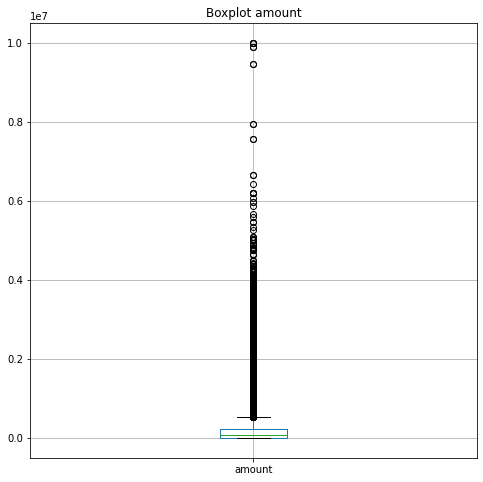

In [8]:
df[['amount']].boxplot(figsize=(8, 8));
plt.title('Boxplot amount');

Система знаходить дуже багато викидів. Викидами в данному випадку вважаються всі суми оперецій, що є дуже великими. На мою думку, видаляти ці записи не потрібно, адже транзакції можуть відбуватись і в дуже великих розмірах.

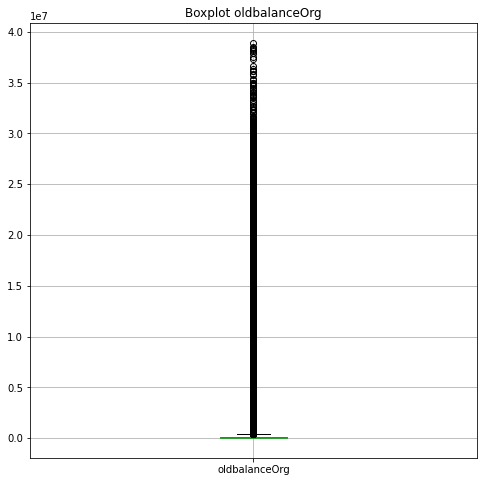

In [9]:
df[['oldbalanceOrg']].boxplot(figsize=(8, 8));
plt.title('Boxplot oldbalanceOrg');

Ситуація схожа з минулою - начебто викидів дуже багато. Але так як досліджуваною змінною є кількість коштів на рахунку, то видаляти записи не потрібно. адже суми на рахунках у кожного можуть бути різні.

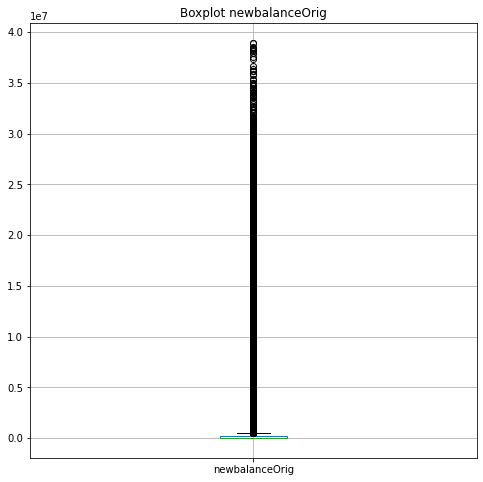

In [10]:
df[['newbalanceOrig']].boxplot(figsize=(8, 8));
plt.title('Boxplot newbalanceOrig');

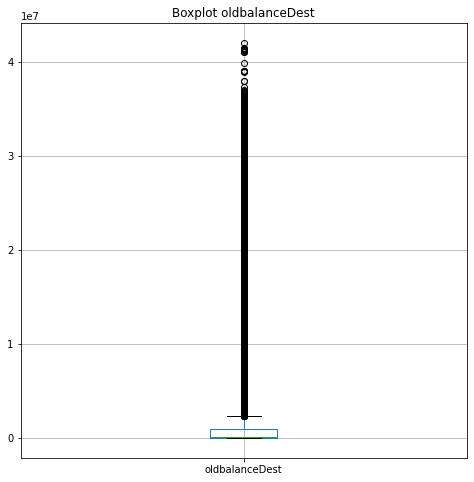

In [11]:
df[['oldbalanceDest']].boxplot(figsize=(8, 8));
plt.title('Boxplot oldbalanceDest');

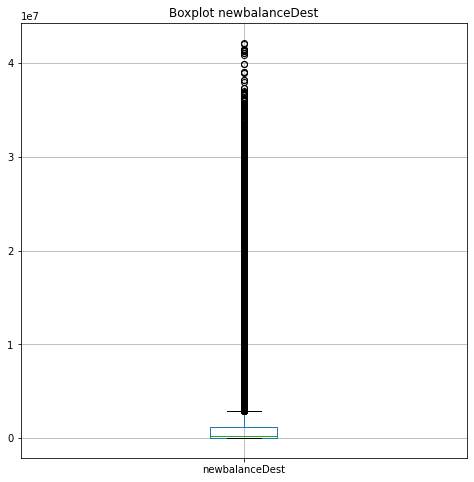

In [12]:
df[['newbalanceDest']].boxplot(figsize=(8, 8));
plt.title('Boxplot newbalanceDest');

Аналогічна ситуація, залишаємо все як є. Через те, що усі змінні відповідають за певний розмір коштів, видаляти дані буде недоцільним, адже об'єктивно визначити викиди не вийде. 

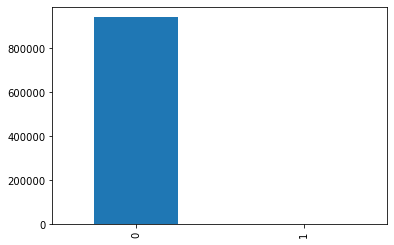

In [13]:
#Побудуємо графік розподілу для категоріальних величин
#Подивимось як розподілена цільова змінна опису транзакції
df['isFraud'].value_counts().plot.bar();

In [14]:
df['isFraud'].value_counts()

0    940943
1       520
Name: isFraud, dtype: int64

За графіком розподілу може здатись, що транзакцій, що відповідають номеру "1"(шахрайські) немає. Але далі після підрахунку кількості записів, що відносяться до певних категорій, видно, що такі транзакції в нашому дататсеті присутні, просто їх кількість значно менша за звичайні не шахрайські транзакції.

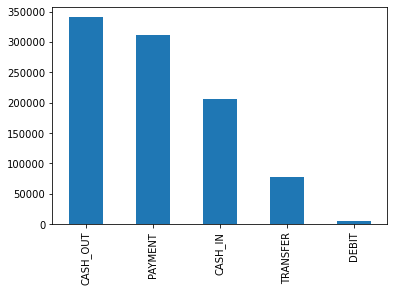

In [15]:
#Подивимось розподіл змінної, що відповідає за тип транзакції
df['type'].value_counts().plot.bar();

In [16]:
df['type'].value_counts()

CASH_OUT    341006
PAYMENT     310938
CASH_IN     205673
TRANSFER     77808
DEBIT         6038
Name: type, dtype: int64

Отже, найчастіше всього у даному наборі даних зустрчаються ті транзакції, що були проведені шляхом знімання готівки(CASH_OUT). З невеликим відривом другу сходинку посіли транзакції, що відбувались під час саме оплати. Наступними за кількістю є транзакції, що були проведені під час того,як людина клала кошти на рахунок. Найменш популярними виявились переказ коштів та дебетові операції.

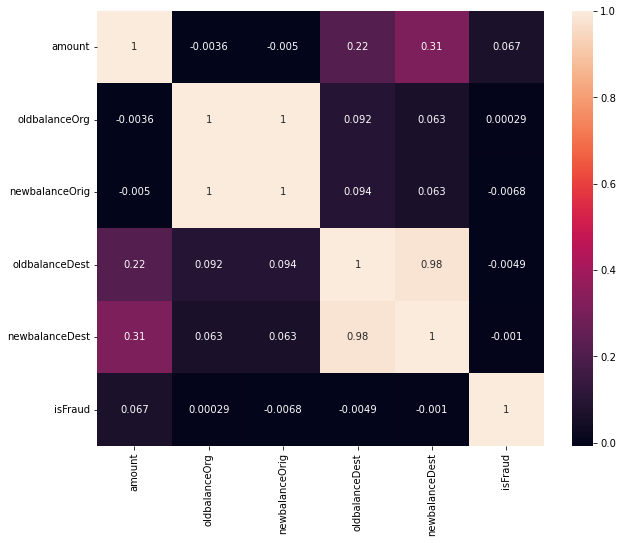

In [18]:
#Для того, щоб зрозуміти чи є якась залежність між характером транзакції та іншими кількісними змінними, будуємо теплову карту
plt.figure(figsize=(10,8));
sns.heatmap(df.corr(), annot=True);

За побудованою тепловою картою одразу видно, що існує пряма 100% залежність між старим балансом одержувача та новим балансом після транзакції. Це не дивно, адже ця інформація є логічною, так само як і з рахунком одержувача(якщо при транзакції був одержувач), кореляція між новою і страрою кількістю грошей на рахунку становить 98%.

Також доволі велика кореляція між балансом одержувача після транзакції та сумою операції, вона становить 31%. Трохи менша залежність, розміром в 22% між тією ж самою сумою операції та старим балансом одержувача.

Між цільовою змінною та іншими кількисними факорами сильної кореляції не спостерігається. Найбільша кореляція між характером транзакції та сумою операції, що становить 6,7%. З іншими показниками спостерігається кореляція менше 1%, тобто є взагалі не суттєвою. До речі між характером транзакції та усіми іншими показниками, окрім старого балансу початкового клієнту, кореляція є від'ємною. Це означає, що залежність між показниками є оберненою(при зростанні одного, інший спадає). Тобто в нашому випадку це означатиме, що якщо isFraund зміниться з 0 на 1(транзакція буде шахрайсьокою), то кошти на рахунках будуть менші, ніж у випадках з нешахрайськими транзакціями. Але, як було сказано раніше, кореляція дуже маленька, тому про таку теорію стверджувати не буде правильним.

In [20]:
#Так як змінні type є категоріальною, то перед побудовою матриці незалежних змінних, цю змінну попередньо необхідно перекодувати в числовий формат. 
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.head()
# Тепер фіктивна змінна type_CASH_OUT приймає такі значення:
# 0 - DEBIT, PAYMENT або TRANSFER
# 1 - CASH_OUT
# І так далі

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


Як можна побачити стовпчик type_CASH_IN не був сформований, це означає, що якщо транзакція за всіма типами приймає значення 0. То тип даної транзакції буде  CASH_IN.

In [21]:
#Визначимо матрицю незалежних змінних (факторів) 
X = df.drop(df[['isFraud']], axis=1)#обираємо усі стовпчики, окрім цільової змінної
print(X.head())

     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0   9839.64       170136.0       160296.36             0.0             0.0   
1   1864.28        21249.0        19384.72             0.0             0.0   
2    181.00          181.0            0.00             0.0             0.0   
3    181.00          181.0            0.00         21182.0             0.0   
4  11668.14        41554.0        29885.86             0.0             0.0   

   type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0              0           0             1              0  
1              0           0             1              0  
2              0           0             0              1  
3              1           0             0              0  
4              0           0             1              0  


In [22]:
#Визначимо вектор залежної (цільової) змінної
y = df['isFraud']#обираємо цільову змінну
print(y.head())

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64


In [23]:
#Стандартизуємо матрицю Х
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.fit_transform(X)

In [24]:
#Розділимо дані на навчальну і тестову вибірки
# Навчальну вибірку використовуємо для навчання моделі
# Тестову вибірку використовуємо для перевірки якості побудованої моделі
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, stratify = y, test_size=0.3, random_state=0)

In [25]:
# Будуємо логістичну регресію
#  Створення і навчання класифікатора  на  навчальному наборі даних
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() 

# навчаємо модель на навчальній вибірці - X_train, y_train
lr.fit(X_train, y_train)

# робимо прогноз цільової змінної на тестовій вибірці - X_test
y_pred_lr = lr.predict(X_test)

In [26]:
#Оцінимо якість класифікатора
from sklearn.metrics import classification_report 
# Порівнюючи  свідчення  класифікатора  (y_pred_lr) з  фактично  відомими  даними тестового набору (y_test),  можна робити висновок про точність класифікатора
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    282283
           1       0.93      0.16      0.27       156

    accuracy                           1.00    282439
   macro avg       0.96      0.58      0.64    282439
weighted avg       1.00      1.00      1.00    282439



Відповідно маємо всього 282439 тестових спостережень, з яких 282283 належить до не шахрайських та лише 156 до шахрайських операцій.

Показник accuracy відповідає за повну точність моделі. Точність являє собою кількість правильно класифікованих екземплярів даних над загальною кількістю екземплярів даних. Тобто точність даної моделі становить 100%, що дуже дивно, адже за іншими показниками ми не можемо сказати про повну тоність, а цей показник каже, що усі значення були класифіковані правильно. Але не завжди показник точності відповідає реальності, ажде деколи дані можуть бути незбалансованими. Тому треба розглядяти і інші показники.

precision - точність. Точність - це відношення правильно передбачених позитивних значень до загальних прогнозованих позитивних значень. В ідеалі точність повинна бути 1 (високою) для хорошого класифікатора. Висока точність свідчить про низький показник хибнопозитивних результатів, на відміну від повної точності. У нашому випадку точність для класифікаціїї характеру транзакції становить 100% для не шахрайських транзакій та 93% для шахрайських. Отже, результати точності є доволі непоганими, бо перший взагалі каже про відсутність хибнопозитивних випадків, а другий знаходяться відносно недалеко від 100%. Однак другий показник біля шахрайських транзакцій є меншим за accuracy, це означає, що серед ознак класифікаційних як шахрайські існує певна кількість хибнопозитивних.

recall - відкликання. Відкликання - це відношення правильно передбачених позитивних значень до фактичних позитивних значень. В ідеалі відкливання має бути 1 (високим) для хорошого класифікатора. Це також буде означати , що FN дорівнює нулю, тобто при класифікації немає хибнонегативних значень. У нашому випадку відкликання становить 100% для не шахрайських транзакій та тільки 16% для шахрайських. Результати першої групи є дуже хорошими, адже вони становлять 100%, а ось для другого вони дуже погані. Це може означати, що дана модель погано класифікує ті транзакції, що виявляться шахрайськими, адже кількість правильно передбачених позитивних значень становить тільки 16% фактичних позитивних значень.

f1-score - середньозважене значення точності та відкликання. Оцінка F1 стає високою лише тоді, коли і точність , і відкликання високі, тому вона є кращим показником, ніж точність, оскільки враховує як хибні випадки, так і хибнонегативні. Отже, в даній класифікації оцінка F1 для характеру транзакції 0 становить 100%, тому ми остаточно можемо казати про ідеальну роботу класифікатора у випадку з нешахрайськими транзакціями, а для 1 - 27%, що є поганим результатом. Тому, класифікація транзакцій, що будуть шахрайськими є не дуже хорошою і тільки для 27% може правильно класифікувати шахрайські транзакції.

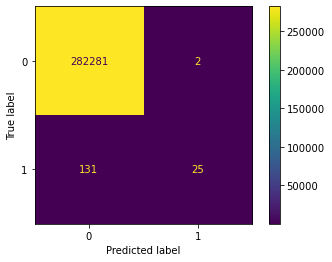

In [27]:
# Побудуємо матрицю помилок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# матриця помилок
cm = confusion_matrix(y_test, y_pred_lr)

# візуалізація матриці помилок
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1']) 
# display_label - задаються назви класів (0 - 1-й клас, 1 - 2-й клас)
cmd.plot()

TP – істино-позитивна відповідь, значення якої можна побачити в лівому верхньому куті. Це ті значення, що були класифіковані, як ті транзакції, що не є шахрайськими і вони справді не були шахрайськими. В нашому випадку більшість значень(282281) є істотно позитивними, що вказує на правильну класифікацію цих значень, що можна було і помітити за розрахунком минулих показників.

FP - помилково-позитивна відповідь, значення якої можна побачити в правому верхньому куті. Це ті значення, що були класифіковані як транзакції, що не є шахрайськими, а вони виявились шахрайськми. Значення цього показника є дуже маленьким, лише 2 випадки. Порівняно з істотно-позитивними значення це майже нічого. Тому можна ще раз наголосити на тому, що операціїщо не є шахрайськими дуже добре класифікуються.

TN - істино-негативна відповідь, значення якої можна побачити в правому нижньому куті. Це ті значення, що були класифіковані, як шахрайські транзакції, і вони справді виявились шахрайськими. Так як при дослудженні було набагато більше записів з не шахрайськими транзакціями, то кількість істотно-негативних значень сама собю буде менша, але в нашому випадку Їх кількість ише 25, що у 5 разів менше за помилково-негативну, отже це говорить про погану класифікацію шахрайських транзакцій.

FN - помилково-негативна відповідь, значення якої можна побачити в лівому нижньому куті. Це ті значення, що були класифіковані як шахрайські транзакції, але вони виявились не шахрайськими. Порівняно з загальною кількістю шахрайських транзакцій, помилково-негативних значень доволі багато - 131, що свідчить про велику кількість транзакцій, що насправді будуть безпечними, але вони класифіковані як шахрайські.

Ми прагнемо до більшої кількості істино-позитивних та істино-негативних результатів, але через неправильну класифікацію ми також бачимо велику кількість хибно- негативних. Таким чином, існує плутанина в класифікації того, буде транзакція шахрайською чи ні. 
Саме тому можна зробити висновок, що даний алгоритм машинного навчання доволі непоганий для класифікації безпечних транзакцій, а ось шахрайсьі транзакції дана модель не може нормально класифікувати, чого ми і прагнули для цієї моделі класифікації. Можливо це пов'язано з тим, що кількість транзакцій, що були виявлені як шахрайські, була значно меншою за кількість безпечних транзакцій, і саме тому класифікатору не вистачило записив для гарного навчання.

In [28]:
# Метод найближчих сусідів
#  Створення і навчання класифікатора  на  навчальному наборі даних
#Спочатку через велику кількість даних в мене не виходило навчити класифікатор даним методом, але згодом все віийшло!!
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

# робимо прогноз на тестовій вибірці - X_test
y_pred_KNN = KNN.predict(X_test)

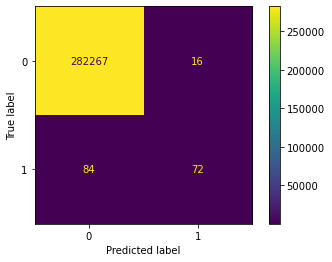

In [29]:
# Побудуємо матрицю помилок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# матриця помилок
cm = confusion_matrix(y_test, y_pred_KNN)

# візуалізація матриці помилок
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1']) 
# display_label - задаються назви класів
cmd.plot()

За побудовою класифікаційної моделі методом найближчих сусідів бачимо певні відмінності з минулою матрицею. Цього разу виявилось трохи більше хибно-позитивних значень(16), але їх кількість є несуттєвою, якщо порівнювати з істотно-позитивними значеннями. І все одно говорить про хорошу класифікацію безпечних транзакцій.

У випадку з істотно-негативними та хибнонегативними значеннями, ситуація стала трохи кращою. Але кількість істотно-негативних все одно трохи менша за хибно-негативні, що говорить про поганеньку класифікацію шахрайських транзакцій. Отже, дана класифікація відбувається правильно приблизно на 50%.

In [30]:
#Оцінимо якість класифікатора
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    282283
           1       0.82      0.46      0.59       156

    accuracy                           1.00    282439
   macro avg       0.91      0.73      0.79    282439
weighted avg       1.00      1.00      1.00    282439



За оцінками якості класифікатора загальна точність моделі та результати показників щодо безпечних транзакцій не відрізняються від класифікації за допомогою побудови логістичної регресії. Усі ці значення так і становлять 100%.

В ситуації із показниками, що відносяться до шахрайських операцій можна сказати, що вони стали набагато кращими. Recall(відкликання) до цього становило 16%, а у даному випадку 46%. F1-score у минулій моделі становив 27%, а тепер 59%, що є навіть більше половини. Precision(точність) стала трохи меншою, але не суттєво. 

Отже, можна стверджувати, що класифікація  методом найближчих сусідів відбувається не ідеально в розрахунку класифікації шахрайських операцій, але вона є кращою за класифікацію за допомогою логістичної регресії.

In [ ]:
#я також намагалась провести класифікацію методом опорних векторів, але через велику кількість даних комп'ютер перенавантажується і йому складно опрацювати таку кількість даних за цим методом
#метод опорних векторів
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
# Побудуємо матрицю помилок
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# матриця помилок
cm = confusion_matrix(y_test, y_pred_svm)

# візуалізація матриці помилок
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1']) 
# display_label - задаються назви класів
cmd.plot()

### Висновки:
- було проведене навчання класифікатора для того, щоб  класифікувати транзакції на шахрайські (той випадок, коли шахраї викрадають кошти з карт) та звичайні транзакції (ті, що відбуваються між звичайними людьми) на основі набору характеристик щодо проведення транзакцій. До цих характеристик входили: тип транзакції, сума проведеної операції, сума коштів на рахунках двох людей, що були замішані у транзакціях, до і після проведення операції. 
- дана задача була вирішена за допомогою бінарної класифікації з використанням Scikit-Learn та за допомогою реалізації таких алгоритмів: метод k-найближчих сусідів (K-Nearest Neighbors) та логічна регресія (Logistic Regression). І виявилось, що найкраще класифікація відбувається при навчанні класифікатора за допомогою методу найближчих сусідів.
- також при класифікації було виявлено, що і перша і друга модель ідеально класифікують транзакції, що є безпечними, а ось при класифікації шахрайських транзакцій з'являється плутанина та модель працює не дуже якісно. 
- у будь-якому випадку кожна класифікаційна модель має свої недоліки і ідеальних моделей не існує. Отже дану модель можна використовувати для подальшої класифікації шахрайських транзакцій. Можливо вона буде працювати краще, якщо для навчання вдасться дадати більше шахрайських транзакцій.

#### Посилання на джерело, з якого були взяті дані:
https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction?resource=download